In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array

import imgaug.augmenters as iaa 
import imgaug as ia 
from imgaug import parameters as iap 
from imgaug.augmenters.arithmetic import Invert
from imgaug.augmenters import size

Found 35654 images belonging to 4 classes.
Found 4041 images belonging to 4 classes.
35654 64
4041
[2 1 1 3 1 2 2 0 1 0 3 3 3 2 0 3 3 1 2 0 0 3 0 0 2 2 1 1 2 3 1 0 1 0 1 2 0
 1 2 1 1 3 3 3 0 2 2 2 2 0 1 3 3 2 3 2 3 3 3 3 0 0 0 0]


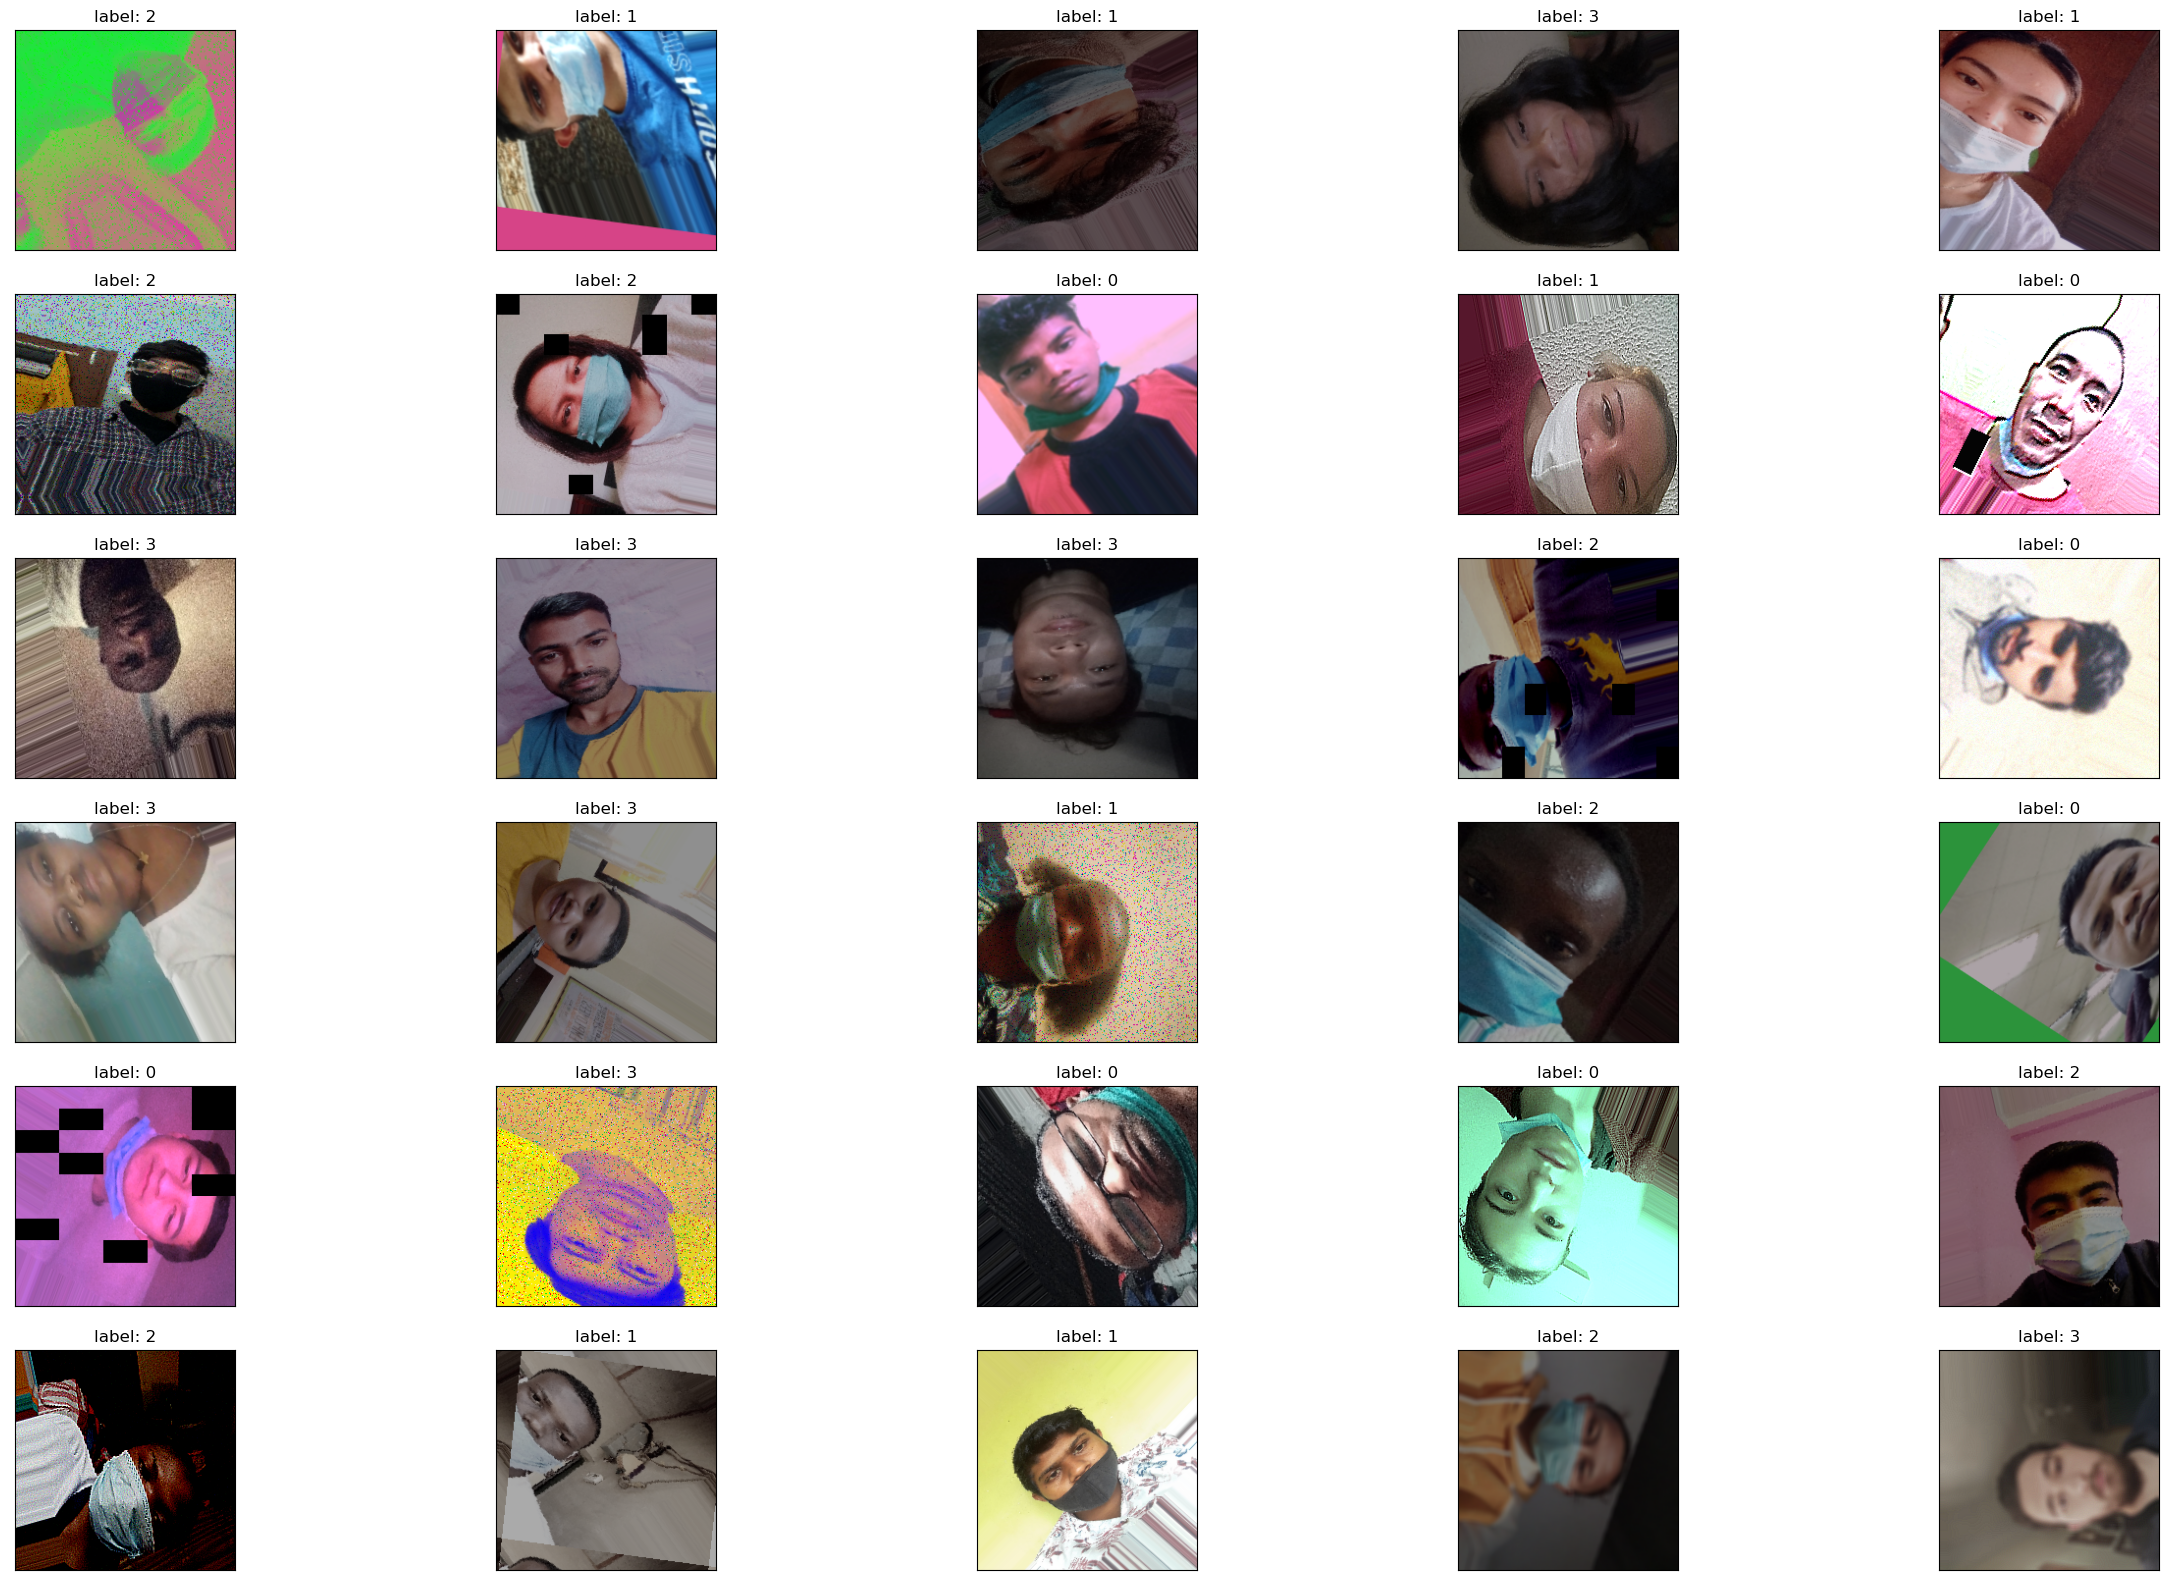

In [3]:
TRAIN_DIR = './mask_dataset/train/'
TEST_DIR = './mask_dataset/test/'

IM_HEIGHT, IM_WIDTH = 224, 224


def sometimes(aug): return iaa.Sometimes(0.1, aug)


seq_train = iaa.Sequential(
    [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.2),


        sometimes(iaa.Crop(percent=(0, 0.1))),










        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),





        iaa.SomeOf((0, 5),
                   [





            sometimes(
                iaa.Superpixels(
                    p_replace=(0, 1.0),
                    n_segments=(20, 200)
                )
            ),





            iaa.OneOf([
                iaa.GaussianBlur((0, 3.0)),
                iaa.AverageBlur(k=(2, 7)),
                iaa.MedianBlur(k=(3, 11)),
            ]),



            iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),


            iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),




            sometimes(iaa.OneOf([
                iaa.EdgeDetect(alpha=(0, 0.7)),
                iaa.DirectedEdgeDetect(
                    alpha=(0, 0.7), direction=(0.0, 1.0)
                ),
            ])),




            iaa.AdditiveGaussianNoise(
                loc=0, scale=(0.0, 0.05*255), per_channel=0.5
            ),




            iaa.OneOf([
                iaa.Dropout((0.01, 0.1), per_channel=0.5),
                iaa.CoarseDropout(
                    (0.03, 0.15), size_percent=(0.02, 0.05),
                    per_channel=0.2
                ),
            ]),



            iaa.Invert(0.05, per_channel=True),



            iaa.Add((-10, 10), per_channel=0.5),


            iaa.Multiply((0.5, 1.5), per_channel=0.5),


            iaa.LinearContrast((0.5, 2.0), per_channel=0.5),



            iaa.Grayscale(alpha=(0.0, 1.0)),


            sometimes(
                iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
            ),


            sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
        ],

            random_order=True
        )
    ],

    random_order=True
)


def img_preprocessing_train(img):

    img = img.reshape(1, img.shape[0], img.shape[1], 3)

    img = img.astype(np.uint8)

    generate_img = seq_train(images=img)

    generate_img = generate_img/255.

    return generate_img.reshape(IM_HEIGHT, IM_WIDTH, 3).astype(np.float32)


train_datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.2],
    zoom_range=[0.8, 1.2],
    preprocessing_function=img_preprocessing_train
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IM_HEIGHT, IM_WIDTH),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IM_HEIGHT, IM_WIDTH),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

print(train_generator.n, train_generator.batch_size)
print(test_generator.n)

img, label = train_generator.next()
label_num = np.argmax(label, 1)
print(label_num)


fig = plt.figure(figsize=(30, 20))

for i in range(30):

    subplot = fig.add_subplot(6, 5, i + 1)

    subplot.set_xticks([])

    subplot.set_yticks([])

    subplot.set_title('label: %d' % label_num[i])

    subplot.imshow(img[i].reshape((IM_WIDTH, IM_HEIGHT, 3)))

plt.show()


In [4]:
print('hello')
import IPython
print(IPython.__version__)

hello
7.31.1


In [5]:
import sys

 

print(sys.version)

3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


In [6]:
# !pip install tensorflow_gpu==2.10.0
# !pip install python==3.7

In [ ]:
!pip install python==3.8.16

In [7]:
import tensorflow
print(tensorflow.__version__)

2.10.0


In [8]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import inspect
from keras import applications
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm
from timeit import default_timer as timer


#모델의 평균 훈련시간을 기록하기 위한 Callback 생성

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs = []

    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer() - self.starttime)


timing_callback = TimingCallback()

# Keras Applications에 있는 모델들을 불러옴
model_dictionary = {
    m[0]: m[1] for m in inspect.getmembers(applications, inspect.isfunction)
}
# EfficientNet 포함된 모델 삭제
keys_to_remove = [
    key
    for key in model_dictionary
    if key.startswith("EfficientNet")
]

for key in keys_to_remove:
    model_dictionary.pop(key, None)

# 모델 확인
for key in model_dictionary:
    print(key)


ConvNeXtBase
ConvNeXtLarge
ConvNeXtSmall
ConvNeXtTiny
ConvNeXtXLarge
DenseNet121
DenseNet169
DenseNet201
InceptionResNetV2
InceptionV3
MobileNet
MobileNetV2
MobileNetV3Large
MobileNetV3Small
NASNetLarge
NASNetMobile
ResNet101
ResNet101V2
ResNet152
ResNet152V2
ResNet50
ResNet50V2
ResNetRS101
ResNetRS152
ResNetRS200
ResNetRS270
ResNetRS350
ResNetRS420
ResNetRS50
VGG16
VGG19
Xception


In [9]:

# 모델들의 성능 기록
model_benchmarks = {
    "model_name": [],
    "num_model_params": [],
    "val_loss": [],
    "val_accuracy": [],
    "avg_train_time": [],
}

for model_name, model in tqdm(model_dictionary.items()):
    # NASNet 모델들은 모델에 맞는 input_shape를 사용해야함
    if "NASNetLarge" in model_name:
        input_shape = (331, 331, 3)
    elif "NASNetMobile" in model_name:
        input_shape = (224, 224, 3)
    # 이외의 모델들은 이미지 최대 크기인 224x224으로 설정
    else:
        input_shape = (224, 224, 3)

    # 베이스 모델 설정
    pre_trained_model = model(include_top=False, input_shape=input_shape)
    pre_trained_model.trainable = False

    # 전이학습 모델 설정
    clf_model = Model(
        inputs=pre_trained_model.input,
        outputs=Dense(4, activation="softmax")(
            GlobalAveragePooling2D()(
                Dense(128, activation="relu")(Dropout(0.5)(pre_trained_model.output))
            )
        ),
    )

    clf_model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    # 모델 훈련
    history = clf_model.fit(
        train_generator,
        epochs=3,  # 많은 모델들을 비교해야하므로 epoch를 3으로 설정
        callbacks=[timing_callback],
        validation_data=test_generator,
    )

    # 모델 성능 비교를 위한 값들을 기록
    model_benchmarks["model_name"].append(model_name)
    model_benchmarks["num_model_params"].append(pre_trained_model.count_params())
    model_benchmarks["val_loss"].append(history.history["val_loss"][-1])
    model_benchmarks["val_accuracy"].append(history.history["val_accuracy"][-1])
    model_benchmarks["avg_train_time"].append(sum(timing_callback.logs) / 3)


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/3


: 

: 

In [ ]:
import pandas as pd

benchmark_df = pd.DataFrame(model_benchmarks)

benchmark_df.to_csv(r'C:\Work\pretrained_model_benchmarks.csv')

bm_params_df = benchmark_df.sort_values('val_accuracy', ascending=False)
bm_params_df.head(10)

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, MobileNet, MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

cb_checkpoint = ModelCheckpoint(filepath=r"C:\Work\DenseNet121B", # 학습 진행시 가장 정확도가 높은 모델을 저장할 경로
                                monitor='val_acc', # 저장할 조건 val_acc (테스트 데이터의 정확도) 가 가장 높은 모델을 저장
                                vervose=1, #함수의 진행 과정 출력
                                save_best_only=True # 가장 정확도가 높은 모델 1개만 저장
                                )